## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Machine Learning Approach](#machine_learning)


<a id='intro'></a>
### Introduction

<span style="color:gray">A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these </span>

<span style="color:gray">For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.</span>


<a id='probability'></a>
#### Part I - Probability

<span style="color:gray">To get started, let's import our libraries.</span>

In [1]:
import pandas as pd
import numpy as np
import random
from patsy import dmatrices
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

<span style="color:gray">`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**</span>

<span style="color:gray">a. Read in the dataset and take a look at the top few rows here:</span>

In [2]:
#Read data 
#Convert the timestamp column into a datatime column type
df = pd.read_csv('ab_data.csv', parse_dates=['timestamp'])

<span style="color:gray">b. Use the cell below to find the number of rows in the dataset.</span>

In [3]:
print('The Number of rows in the dataset is: {}'.format(len(df)))

The Number of rows in the dataset is: 294478


<span style="color:gray">c. The number of unique users in the dataset.</span>

In [4]:
print('The Number of Unique Users is: {}'.format(df.user_id.nunique()))

The Number of Unique Users is: 290584


<span style="color:gray">d. The proportion of users converted.</span>

In [5]:
percentage_converted = df.converted.value_counts(normalize=True)[1]*100
print('The Proportion of Users Converted is: {:.2f}%'.format(percentage_converted))

The Proportion of Users Converted is: 11.97%


<span style="color:gray">e. The number of times the `new_page` and `treatment` don't match.</span>

In [6]:
print('Number of times the new_page and treatment don\'t match is: {}'\
      .format(len(df.query('group == "treatment" & landing_page != "new_page"'))))

Number of times the new_page and treatment don't match is: 1965


<span style="color:gray">f. Do any of the rows have missing values?</span>

In [7]:
print('Checking for Missing Values:')
print('------------------')
print(df.isnull().sum())
print('------------------')
print('No Missing Values')

Checking for Missing Values:
------------------
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
------------------
No Missing Values


<span style="color:gray">`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  </span>

<span style="color:gray">a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.</span>

In [8]:
#Create a list of indexes, where the condition is:
#treatment does not match with new_page or control does not match with old_page
remove_list = df.query(
                '(group == "treatment" & landing_page != "new_page") | \
                (group == "control" & landing_page != "old_page")').index

#Drop the remove_list from the dataframe
df2 = df.drop(remove_list)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

<span style="color:gray">`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.</span>

<span style="color:gray">a. How many unique **user_id**s are in **df2**?</span>

In [10]:
#we use "nunique" method on pandas series to get number of unique values
print('The Number of Unique Users is: {}'.format(df2.user_id.nunique()))

The Number of Unique Users is: 290584


<span style="color:gray">b. There is one **user_id** repeated in **df2**.  What is it?</span>

In [11]:
dup_user_id = df2[df2.duplicated(subset=['user_id'])]['user_id']
print('The repeated User Id in df2 is: {}'.format(dup_user_id.values[0]))

The repeated User Id in df2 is: 773192


<span style="color:gray">c. What is the row information for the repeat **user_id**? </span>

In [12]:
print('Repeated User Id Info:')
print('------------------------------------------------------------------------------')
print(df2[df2.duplicated(subset=['user_id'])])
print('------------------------------------------------------------------------------')

Repeated User Id Info:
------------------------------------------------------------------------------
      user_id                  timestamp      group landing_page  converted
2893   773192 2017-01-14 02:55:59.590927  treatment     new_page          0
------------------------------------------------------------------------------


<span style="color:gray">d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.</span>

In [13]:
#Drop the duplicated user id using dup_user_id calculated above
df2.drop(dup_user_id.index, inplace=True)

<span style="color:gray">`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.</span>

<span style="color:gray">a. What is the probability of an individual converting regardless of the page they receive?</span>

In [14]:
p_conv = df2.converted.value_counts(normalize=True)[1].round(4)
print('Probability of Converting is: {}'.format(p_conv))

Probability of Converting is: 0.1196


<span style="color:gray">b. Given that an individual was in the `control` group, what is the probability they converted?</span>

In [15]:
p_control_conv = df2.query('group == "control"').converted.value_counts(normalize=True)[1].round(4)
print('Probability of Converting in Control group is: {}'.format(p_control_conv))

Probability of Converting in Control group is: 0.1204


<span style="color:gray">c. Given that an individual was in the `treatment` group, what is the probability they converted?</span>

In [16]:
p_control_treat = df2.query('group == "treatment"').converted.value_counts(normalize=True)[1].round(4)
print('Probability of Converting in Treatment group is: {}'.format(p_control_treat))

Probability of Converting in Treatment group is: 0.1188


<span style="color:gray">d. What is the probability that an individual received the new page?</span>

In [17]:
p_new_page = df2.landing_page.value_counts(normalize=True)[0].round(3)
print('Probability that an Individual Received The New Page is: {}'.format(p_new_page))

Probability that an Individual Received The New Page is: 0.5


<span style="color:gray">e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.</span>

**$The~probabilities~are~as~follows:$<br> <br>**


**$p_{converting} = 0.1196$<br>
$p_{converting/control} = 0.1204$<br>
$p_{converting/treatment} = 0.1188$<br>
$p_{new} = 0.5$<br><br>**


**$With~~the~probability~of~an~individual~reveived~the~new~page~is$ $0.5,$<br> $and ~~p_{converting} ~= p_{converting/control} ~= p_{converting/treatment} = 0.12~~probabilities~~are~~almost~~identical.$ <br> $Chances~for~the~new~treatment~page~leads~to~ more~conversions~are~low,~and~it~provides~no~sufficient~evidence.$<br>**

<a id='ab_test'></a>
### Part II - A/B Test

<span style="color:gray">Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  </span>

<span style="color:gray">However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  </span>

<span style="color:gray">These questions are the difficult parts associated with A/B tests in general.  </span>


<span style="color:gray">`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.</span>

------------------------------------
<h1><center>
$~~~~~~~~~~~Null~Hypothesis~H_{0}:~p_{new}~\leqslant~p_{old}~$<br>
$Alternative~Hypothesis~H_{1}:~p_{new}~>~p_{old}~$</center></h1><end>   
    
------------------------------------

<span style="color:gray">`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br></span>

<span style="color:gray">Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br></span>

<span style="color:gray">Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br></span>

<span style="color:gray">Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br></span>

<span style="color:gray">a. What is the **conversion rate** for $p_{new}$ under the null? </span>

In [18]:
p_new = p_old = df2.converted.value_counts(normalize=True)[1].round(4)
print('The conversion rate for p_new is: {}'.format(p_new))

The conversion rate for p_new is: 0.1196


<span style="color:gray">b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
print(p_old)
print('The conversion rate for p_new is: {}'.format(p_old))

0.1196
The conversion rate for p_new is: 0.1196


<span style="color:gray">c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
treatment = df2[df2.group == 'treatment']
n_new = len(treatment)
print('The number of individuals in the treatment group is: {}'.format(n_new))

The number of individuals in the treatment group is: 145310


<span style="color:gray">d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
control = df2[df2.group == 'control']
n_old = len(control)
print('The number of individuals in the contorl group is: {}'.format(n_old))

The number of individuals in the contorl group is: 145274


<span style="color:gray">e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
#Use "sample" method in pandas and set replace equal to true in order to sample with replacement
new_page_converted = treatment.sample(n=n_new, replace=True)

<span style="color:gray">f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = control.sample(n=n_old, replace=True)

<span style="color:gray">g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff = p_control_treat - p_control_conv
print('p_new - p_old = {}'.format(diff))

p_new - p_old = -0.0015999999999999903


<span style="color:gray">h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
#Create empty list
p_diffs = []
#loop 10000 times, make bootstrap samples, append the list with the mean difference
for _ in range(10000):
    sample = df2.sample(n=len(df2), replace=True)
    new_page_converted = sample[sample.group == 'treatment']
    old_page_converted = sample[sample.group == 'control']
    p_diff = new_page_converted.converted.mean() - old_page_converted.converted.mean()
    p_diffs.append(p_diff)

<span style="color:gray">i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

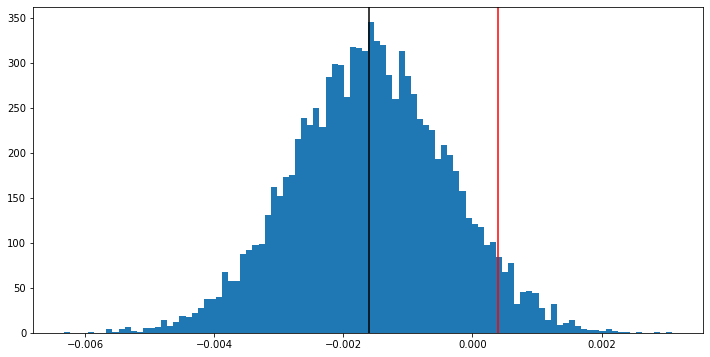

In [26]:
#plot histogram of p_diffs with vertical line at the right trail and the actual difference(p_new - p_old)
plt.figure(figsize=(12,6))
plt.hist(p_diffs, bins=100)
plt.axvline(np.percentile(p_diffs, 95), color='r')
plt.axvline(diff, color='k');

<span style="color:gray">j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
print('Propotion of p_diffs > diff = {}'.format((p_diffs > diff).mean()))

Propotion of p_diffs > diff = 0.5072


<span style="color:gray">k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Note that getting a probability mean difference greater than the actual difference is 0.5134, which is greater than the alpha value of 1/20 (False positive rate) which means that we will `not reject the null hypothesis` which says that the new page conversion rate is greater than old page conversion rate.</br>**

**As a conclusion, our new page is not better than our old page.**

<span style="color:gray">l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.converted.value_counts()[0]
convert_new = df2.converted.value_counts()[1]
n_old = len(control)
n_new = len(treatment)

<span style="color:gray">m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
stat , pval = sm.stats.proportions_ztest(count = df2.converted.sum(), nobs=len(df2), value = p_conv, alternative='larger')
print('Z-Stat:{:.4f}'.format(stat))
print('P-Value: {:.4f}'.format(pval))

Z-Stat:-0.0048
P-Value: 0.5019


<span style="color:gray">n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### What Is a Z-Test?<br>
A Z-test is a statistical test used to determine whether two population means are different when the variances are known, and the sample size is large. The test statistic is assumed to have a normal distribution, and nuisance parameters such as standard deviation should be known in order for an accurate z-test to be performed.<br>


A z-statistic, or z-score, is a number representing how many standard deviations above or below the mean population a score derived from a z-test is. **Reference: [Investopedia](https://www.investopedia.com/terms/z/z-test.asp)**<br>

**`Z-Stat is negative and less than 1.96`, so we `do not Reject the Null hypothesis` which stats that the `conversion rate did not improve in the new page.`<br>
`P-Value is greater than 0.05`, which means we `do not Reject the Null hypothesis` which stats that the `conversion rate did not improve in the new page.`<br><br>
The above tests supports our finding in parts `j` & `k` that the conversion rate did not improve.**

<a id='regression'></a>
### Part III - A regression approach

<span style="color:gray">`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

<span style="color:gray">a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we have only 2 outcomes from the data, then it’s a `Binary Classification Problem`,
<br> which means that we can use a `Logistic Regression Algorithm/model.`**

<span style="color:gray">b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
#add an intercept
df2['intercept'] = 1
#dummy code the group column with treatment group set to 1 and control group set to 0
df2['ab_page'] = (df2.group == 'treatment')*1
#dummy code the landing_page with new page set to 1 and old page set to 0
df2['new_page'] = (df2.landing_page == 'old_page')*1
#create a features(X) dataframe and a target(y) Series
features = df2[['intercept', 'new_page', 'ab_page']]
target = df2['converted']

<span style="color:gray">c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
#instantiate logistic regression model
model = sm.Logit(target, features)
#fit the model
results = model.fit()

         Current function value: 0.366118
         Iterations: 35


C:\Users\Amer\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<span style="color:gray">d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
#print model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:               8.077e-06
Time:                        01:07:22   Log-Likelihood:            -1.0639e+05
converged:                      False   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3308    1.5e+05  -8.84e-06      1.000   -2.95e+05    2.95e+05
new_page      -0.6579    1.5e+05  -4.37e-06      1.000   -2.95e+05    2.95e+05
ab_page       -0.6729    1.5e+05  -4.47e-06      1.000   -2.95e+05    2.95e+05
==============================================================================
"""

<span style="color:gray">e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**In `Part II` we were testing the significance of the probability for getting `New Page Conversion Rate Greater than the Old Page Conversion Rate, whereas in the `Logistic Regression Model` we are testing the statistical significance of the `Coefficients` if it's `Different From Zero.`**

------------------------------------
<h1><center>
$~~~~~~~~~~~Null~Hypothesis~H_{0}:~\beta_{coefficient}~=0~$<br>
$Alternative~Hypothesis~H_{1}:~\beta_{coefficient}~\neq~0~$</center></h1>   
    
------------------------------------
**Since the P-value for our features is equal to `1 which is greater than 0.05`, this model states that the used features provide no statistical significance and the `coefficients`$\beta$ `are Not different from ZERO`**

<span style="color:gray">f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Our existing features provide no statistical significance, so it's a good idea to search and add other features that might enhance the predicting power of our regression model, but one main disadvantage of adding additional features is that we might see correlation, but it should not be interpreted as a causality between our independent variable(s) X and our dependent variable y .**

<span style="color:gray">g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

<span style="color:gray">Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns

In [33]:
#Read the countries.csv and assign it to the countries variable
countries = pd.read_csv('countries.csv')
#Join df2 and countries dataframes under the variable combined
combined = df2.set_index('user_id').join(countries.set_index('user_id'))

In [34]:
#create dummies for the country column and inspect the head of the combined dataframe
combined[['CA', 'UK', 'US']] = pd.get_dummies(combined.country)
combined.head()

,timestamp,group,landing_page,converted,intercept,ab_page,new_page,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [35]:
#drop the dummy column 'US' and create a features2 columns and target2 column
features2 = combined[['intercept', 'new_page', 'ab_page', 'UK', 'US']]
target2 = combined['converted']
#instantiate fit and get model2 summary results
model2 = sm.Logit(target2, features2)
results2 = model2.fit()
results2.summary()

         Current function value: 0.366113
         Iterations: 35


C:\Users\Amer\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:               2.323e-05
Time:                        01:07:26   Log-Likelihood:            -1.0639e+05
converged:                      False   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3584        nan        nan        nan         nan         nan
new_page      -0.6717        nan        nan        nan         nan         nan
ab_page       -0.6866        nan        nan        nan         nan         nan
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**The P-values for UK & US are 0.074 & 0.13 respectively, which means `country` column have an impact on the conversion rate, compared to the previous P-values of 1 for the new_page and the ab_page.**

<span style="color:gray"><span style="color:gray">h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

<span style="color:gray">Provide the summary results, and your conclusions based on the results.

In [36]:
#we can create an interaction terms using patsy package
#see documentation for more details: https://patsy.readthedocs.io/en/latest/formulas.html
target3, features3 = dmatrices('converted ~ ab_page:country', data=combined, return_type='dataframe')

In [37]:
#inspect features3 dataframe
features3.head()

,Intercept,ab_page:country[CA],ab_page:country[UK],ab_page:country[US]
user_id,,,,
851104,1.0,0.0,0.0,0.0
804228,1.0,0.0,0.0,0.0
661590,1.0,0.0,0.0,1.0
853541,1.0,0.0,0.0,1.0
864975,1.0,0.0,0.0,0.0


In [38]:
#instantiate fit and get model3 summary results
model3 = sm.Logit(target3, features3)
results3 = model3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:               3.351e-05
Time:                        01:07:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.06785
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page:country[CA]    -0.0827      0.038     -2.176      0.030      -0.157      -0.008
ab_page:country[UK]     0.0074      0.018      0.410      0.682      -0.028       0.043
ab_page:country[US]    -0.0183      0.013     -1.449      0.147      -0.043       0.006
=======================================================================================
"""

**The model improved with one interaction term between ab_page and country CA having a P-value = 0.03 < 0.05 which is statistically significant.**</br>

**As a conclusion, adding an interaction term provided some evidence between `group with country` and `conversion rate`, but this model still lacks in its overall statistical significance since most of its features still have a P-value more than 0.05.**

**`Practically, we need more information on the cost of conversion when implementing the new page to decide whether it’s worth it investing in this implementation or not.`**

--------------------

<a id='machine_learning'></a>
### Part IV - Machine Learning Approach

Based on the final section of the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric) we can add the influences associated with time on conversion. We can achieve this by creating additional columns for the `day of week `and maybe `hour in day` the conversion happened.

In [39]:
#Create a dataframe named ml(machine learning) from our previous data
ml = combined[['converted', 'ab_page', 'new_page', 'UK', 'US', 'timestamp']]
#inspect the type of columns we have
ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 851104 to 715931
Data columns (total 6 columns):
converted    290584 non-null int64
ab_page      290584 non-null int32
new_page     290584 non-null int32
UK           290584 non-null uint8
US           290584 non-null uint8
timestamp    290584 non-null datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(1), uint8(2)
memory usage: 19.4 MB


**we can see that timestamp column is of type datetime64, which have special functions that can help dealing with it.</br>** 

**Note that I had already converted the timestamp column to a `datetime type` using `'parse_date' keyword argument` at the start of the project.**

In [40]:
#Extract the day of week and hour of day from our timestamp column using pandas datetime functions
ml['dayofweek'] = ml.timestamp.dt.dayofweek
ml['hour'] = ml.timestamp.dt.hour

In [41]:
#Inspect the extracted values
ml.head()

,converted,ab_page,new_page,UK,US,timestamp,dayofweek,hour
user_id,,,,,,,,
851104,0,0,1,0,1,2017-01-21 22:11:48.556739,5,22
804228,0,0,1,0,1,2017-01-12 08:01:45.159739,3,8
661590,0,1,0,0,1,2017-01-11 16:55:06.154213,2,16
853541,0,1,0,0,1,2017-01-08 18:28:03.143765,6,18
864975,1,0,1,0,1,2017-01-21 01:52:26.210827,5,1


In [42]:
#from pandas documentation: 'dt.dayofweek' method gives The number of the day of the week with Monday=0, Sunday=6
days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
ml[days] = pd.get_dummies(ml.dayofweek)
ml.head()

,converted,ab_page,new_page,UK,US,timestamp,dayofweek,hour,mon,tue,wed,thu,fri,sat,sun
user_id,,,,,,,,,,,,,,,
851104,0,0,1,0,1,2017-01-21 22:11:48.556739,5,22,0,0,0,0,0,1,0
804228,0,0,1,0,1,2017-01-12 08:01:45.159739,3,8,0,0,0,1,0,0,0
661590,0,1,0,0,1,2017-01-11 16:55:06.154213,2,16,0,0,1,0,0,0,0
853541,0,1,0,0,1,2017-01-08 18:28:03.143765,6,18,0,0,0,0,0,0,1
864975,1,0,1,0,1,2017-01-21 01:52:26.210827,5,1,0,0,0,0,0,1,0


In [43]:
#Create a target variable y and feature variable X, dropping Monday to create a full rank matrix
y = ml['converted']
X = ml[['ab_page', 'new_page', 'UK', 'US'] + days[1:]]

In [44]:
#instantiate fit and get model4 summary results
model4 = sm.Logit(y, X)
results4 = model4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366103
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290574
Method:                           MLE   Df Model:                            9
Date:                Mon, 16 Mar 2020   Pseudo R-squ.:               4.925e-05
Time:                        01:07:30   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3131
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page       -2.0303      0.030    -68.301      0.000      -2.089      -1.972
new_page      -2.0154      0.030    -67.811      0.000      -2.074      -1.957
UK             0.0507      0.028      1.787      0.074      -0.005       0.106
US             0.0407      0.027      1.514      0.130      -0.012       0.093
tue           -0.0153      0.020     -0.756      0.450      -0.055       0.024
wed           -0.0076      0.021     -0.359      0.719      -0.049       0.034
thu           -0.0111      0.021     -0.524      0.600      -0.053       0.030
fri           -0.0425      0.021     -2.000      0.045      -0.084      -0.001
sat           -0.0031      0.021     -0.146      0.884      -0.044       0.038
sun           -0.0254      0.021     -1.202      0.229      -0.067       0.016
==============================================================================
"""

**We Can see that the `group, page type, UK country, and dayofweek with Friday all have P-values less than 0.05 which is statistically significant`**</br>

**Surprisingly the `group`, and the `page type` are now statistically significant when combined with time influence, also `United Kingdom` on `Friday` have `significant effects on conversion.`.**

------------

### Other Machine Learning Models

**In this section I'm going to use 2 different models and choose the one that gives the best score, then compare it to our base Logistic Regression base model.**

In [45]:
#make necessary imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix

In [46]:
#create a dataframe named 'data' from our previous data
data = combined[['converted', 'group', 'landing_page', 'country']]
#extract dayofweek and hour from the timestamp column
data['dayofweek'] = combined.timestamp.dt.dayofweek
data['hour'] = combined.timestamp.dt.hour

In [47]:
#convert all data types to string/object type for use in patsy package
data = data.astype(str)
#Make an interaction term using group column with all other variables
indep_list = 'group:landing_page + group:country + group:dayofweek + group:hour'
ml_target, ml_features = dmatrices('converted ~ {}'.format(indep_list), data=data, return_type='dataframe')

In [48]:
#Make train/test split with 30% of data is held out for testing.
#The spilt will be stratified since our data have imbalanced classes.
X_train, X_test, y_train, y_test = train_test_split(ml_features, ml_target.iloc[:,1], test_size=0.3, random_state=42, stratify=ml_target)

In [49]:
#create empty list to append models with scores in it
model_list = []
#instentiate a list of models
models = [RandomForestClassifier(), GaussianNB(), LogisticRegression()]
#create the name of the models
models_name = ['Random Forest', 'Naive Bayes', 'Logistic Regression']
#loop through the models
for model, name in zip(models, models_name):
    #fit the models on the training data
    model.fit(X_train, y_train)
    #make predictions on the testing data
    pred = model.predict(X_test)
    #calculate precision score for model evaluation
    precision = precision_score(y_test, pred)
    #calculate the confusion matrix for our predictions
    confusion = confusion_matrix(y_test, pred)
    #Append the models into a list of dictionaries
    model_list.append({'Model Name': name,
                       'Precision Score %': precision,
                       'Confusion Matrix': confusion})
#convert the dictionary into a pandas dataframe for better visualization
models_df = pd.DataFrame(model_list).set_index('Model Name')

In [50]:
#Print the model's dataframe
models_df[['Precision Score %']].round(4)*100

,Precision Score %
Model Name,
Random Forest,0.00
Naive Bayes,13.09
Logistic Regression,0.00


In [51]:
#Convert the confustion matrix for our winning model(Naive Bayes Classfier) into a pandas dataframe 
pd.DataFrame(models_df.iloc[1,1], index=['True No Conversion', 'True Conversion'], 
             columns=['Predicted No Conversion', 'Predicted Conversion'])

,Predicted No Conversion,Predicted Conversion
True No Conversion,73482,3268
True Conversion,9934,492


## Conclusion


**Using the Precision Score as an evaluation for model performance on our held testing data, we can see that our Naive Bayes Classifier with 13% precision Out-Performed both our Base Logistic Regression Model and Random Forest Model both with 0% Precision in Predicting the Conversion Rate.**</b>

**Note That I had used Precision Score as an evaluation matrix since we have an imbalanced class in our target variable which is in this case the `converted` column.**</b>

**Our model can be further improved by:**

> **Adding more interaction features (i.e. `landing_page` with `country` column, etc...)**

> **Consider making 3 interaction features at a time (i.e. `group` with `landing_page` with `country`, etc...)**

> **Adjusting hyperparameters of our Naive Bayes Classifier (i.e. `Hyperparameter tuning`)**